## Action Plan
### Build model by LUNA to train Data Bowl 2017
1. Data Preprocessing on Data Bowl 2017 data
2. Data Preprocessing on LUNA data for **generate Regions of Interest candidates by Segmentation** 
3. Train Model to **generate Regions of Interest candidates by Segmentation** 
4. Data Preprocessing on LUNA data for **Classification of Lung Nodules **
5. Train Model for **Classification of Lung Nodules **
6. Generate and Validate Predictions 
7. Submit predictions to Kaggle

In [2]:
%pwd

'/home/ubuntu/kaggle/data-bowl-2017/Code'

In [3]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
CODE_HOME_DIR = current_dir
DATA_HOME_DIR = CODE_HOME_DIR + '/../input/'
print(CODE_HOME_DIR)
print(DATA_HOME_DIR)

/home/ubuntu/kaggle/data-bowl-2017/Code
/home/ubuntu/kaggle/data-bowl-2017/Code/../input/


#### Setup Paths

In [197]:
#%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + 'sample_images/' # + '/'
anno_path = DATA_HOME_DIR + '/'
output_path = DATA_HOME_DIR + '/output/'
if not os.path.exists(output_path): os.makedirs(output_path)
'''
results_path = path + 'results/'
train_path = path + 'train/'
valid_path = path + 'valid/'
test_path = path + 'test/'
model_path = path + 'models/'
if not os.path.exists(model_path): os.makedirs(model_path)
''' 
batch_size = 64

In [214]:
%matplotlib inline

from importlib import reload
import dataprep_databowl; reload(dataprep_databowl)
from dataprep_databowl import *
import utils_databowl; reload(utils_databowl)
from utils_databowl import *

In [198]:
df_labels = pd.read_csv(anno_path+'stage1_labels.csv')

In [199]:
df_labels[:5]

,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0
2,003f41c78e6acfa92430a057ac0b306e,0
3,006b96310a37b36cccb2ab48d10b49a3,1
4,008464bb8521d09a42985dd8add3d0d2,1


In [202]:
patients = os.listdir(path)
patients.sort()
print('total patients:', len(patients))

total patients: 20


In [200]:
p2cancer = {p:df_labels[df_labels.id==p].iloc[-1]['cancer'] for p in patients 
            if p in np.array(df_labels['id'])}

### Loading the files and transform into Hounsfield Unit (HU)

The unit of measurement in CT scans is the **Hounsfield Unit (HU)**, which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this.  From Wikipedia:

![HU examples][1]

By default however, the returned values are not in this unit. Let's fix this.

Some scanners have cylindrical scanning bounds, but the output image is square. The pixels that fall outside of these bounds get the fixed value -2000. The first step is setting these values to 0, which currently corresponds to air. Next, let's go back to HU units, by multiplying with the rescale slope and adding the intercept (which are conveniently stored in the metadata of the scans!).

  [1]: http://i.imgur.com/4rlyReh.png

In [124]:
# get all patient ids with cancer to make sure it works well for cancer cases
cancer_patient_ids = [p for p,c in p2cancer.items() if c==1]

In [133]:
# TODO
problem_patient_ids = ['0acbebb8d463b4b9ca88cf38431aac69']

'0acbebb8d463b4b9ca88cf38431aac69'

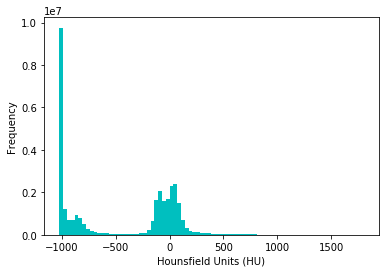

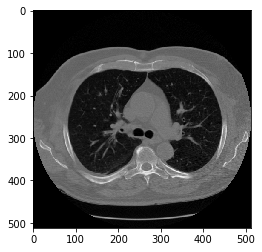

In [179]:
#first_patient = load_scan(path + patients[first_cancer_patient_id])
first_patient = load_scan(os.path.join(path, cancer_patient_ids[1]))
first_patient_pixels = get_pixels_hu(first_patient)
plot_pixels(first_patient_pixels, slice_idx=view_slice_idx)

### Resampling

In [180]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (123, 512, 512)
Shape after resampling	 (308, 355, 355)


In [181]:
resample_multiple = (pix_resampled.shape[0]/first_patient_pixels.shape[0])

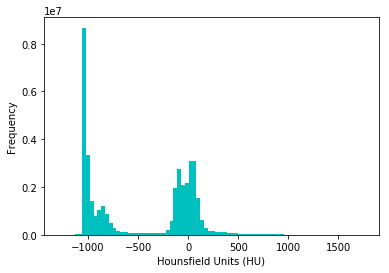

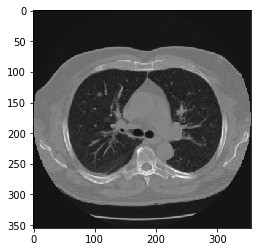

In [182]:
plot_pixels(pix_resampled , slice_idx=int(slice_idx*resample_multiple))

### Lung segmentation

In [183]:
#segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

In [184]:
segmented_lungs_fill.shape

(308, 355, 355)

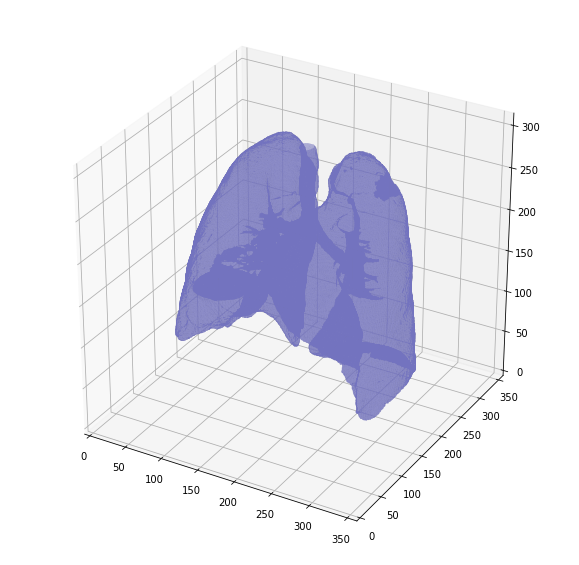

In [196]:
plot_3d(segmented_lungs_fill, threshold=0)

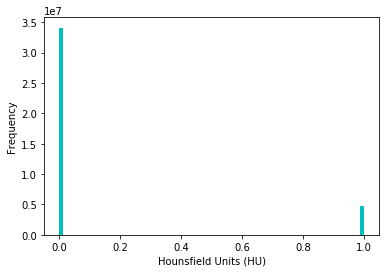

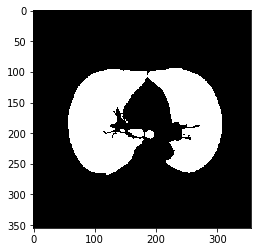

In [186]:
plot_pixels(segmented_lungs_fill, slice_idx=slice_idx_resampled)

In [187]:
pix_resampled[i].dtype, segmented_lungs_fill[i].dtype

(dtype('int16'), dtype('int8'))

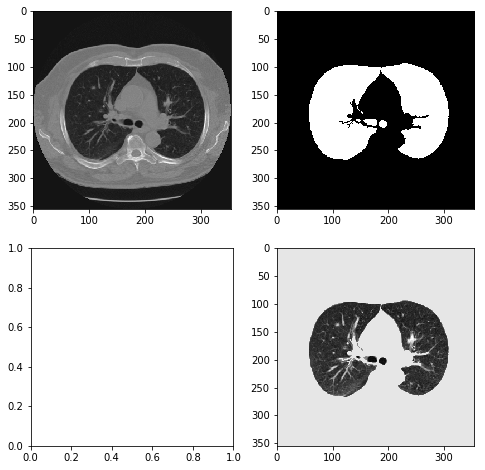

In [188]:
i = slice_idx_resampled
fig,ax = plt.subplots(2,2,figsize=[8,8])
ax[0,0].imshow(pix_resampled[i],cmap='gray')
ax[0,1].imshow(segmented_lungs_fill[i],cmap='gray')
#ax[1,0].imshow((matrix2uint16(imgs[i])),cmap='gray')
ax[1,1].imshow((pix_resampled*segmented_lungs_fill)[i],cmap='gray')
plt.show()

## Put all above steps together to save as files 

In [208]:
for pid in patients:
    slice_idx=80 # to view the middle slice before resampled (defined as 80)
    
    '''Loading the files and transform into Hounsfield Unit (HU)'''
    patient = load_scan(os.path.join(path, pid))
    patient_pixels = get_pixels_hu(patient)
    
    '''Resampling'''
    pix_resampled, spacing = resample(patient_pixels, patient, [1,1,1])
    # mapping to correct slice_idx after resampled 
    resample_multiple = (pix_resampled.shape[0]/first_patient_pixels.shape[0])
    np.save(os.path.join(output_path,"pixels_%s.npy" % pid), pix_resampled)
    np.save(os.path.join(output_path,"spacing_%s.npy" % pid), spacing)
    np.save(os.path.join(output_path,"resample_multiple_%s.npy" % pid), resample_multiple)
    
    '''Lung segmentation'''
    segmented_lungs_fill = segment_lung_mask(pix_resampled, True)
    np.save(os.path.join(output_path,"lungmask_%s.npy" % pid), segmented_lungs_fill)

In [215]:
file_list = glob(output_path+"pixels*.npy"); print(len(file_list))

20


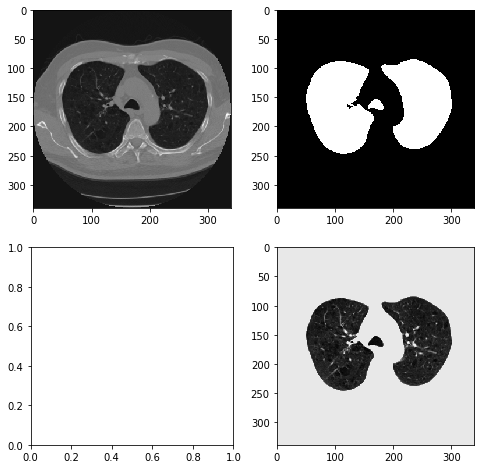

In [212]:
pn = 2
pid = patients[pn]
slice_idx = 80

pix_resampled = np.load(os.path.join(output_path,"pixels_%s.npy" % pid))
resample_multiple = np.load(os.path.join(output_path,"resample_multiple_%s.npy" % pid))
segmented_lungs_fill = np.load(os.path.join(output_path,"lungmask_%s.npy" % pid))

i = int(slice_idx*resample_multiple)
#plot_pixels(pix_resampled , slice_idx=i)

fig,ax = plt.subplots(2,2,figsize=[8,8])
ax[0,0].imshow(pix_resampled[i],cmap='gray')
ax[0,1].imshow(segmented_lungs_fill[i],cmap='gray')
ax[1,1].imshow((pix_resampled*segmented_lungs_fill)[i],cmap='gray')
plt.show()